In [24]:
import duckdb
import pandas as pd

In [25]:
import time

def run_query_duckdb(query,cur):
    
    start_time = time.perf_counter() 
    res = cur.execute(query).fetch_df() 
    end_time = time.perf_counter()

    elapsed_time_ms = (end_time - start_time)*1000    

    print(f"\n Query executed in {elapsed_time_ms:.2f} ms")
    
    if not res.empty:
        print(res.head())
        return res
    else:
        print("\n No rows returned.")

In [26]:
con = duckdb.connect('mydb.duckdb')

# Test Query 
query = 'SELECT * FROM people_large'

df = run_query_duckdb(query,con,)



 Query executed in 510.39 ms
   Index          User Id First Name   Last Name     Sex  \
0      1  db484997Aa2e723     Marcia    Morrison  Female   
1      2  B117e5DCACf270A     Ashley        Yang    Male   
2      3  32cbC09A5bcDb1b     Tracie  Hutchinson  Female   
3      4  06Eea7aF9760fD0    Jeffrey       Moody    Male   
4      5  CE52aEd4F9AE60C       Bill        Dyer    Male   

                        Email                  Phone Date of birth  \
0  yvonnemcknight@example.net      892.956.5029x7469    1963-06-30   
1   jenningsdevon@example.com             4099852413    1922-08-04   
2      drodriguez@example.net           493-888-0693    1931-08-12   
3        nburnett@example.org  001-654-763-5970x3318    1972-10-31   
4      destinyday@example.net       024-165-5814x001    2017-05-29   

                             Job Title  age  
0                         Set designer   62  
1                     Location manager  103  
2                         Retail buyer   94  
3   

In [27]:
df.set_index('Index',inplace=True)

In [28]:
df.head(10)

,User Id,First Name,Last Name,Sex,Email,Phone,Date of birth,Job Title,age
Index,,,,,,,,,
1,db484997Aa2e723,Marcia,Morrison,Female,yvonnemcknight@example.net,892.956.5029x7469,1963-06-30,Set designer,62
2,B117e5DCACf270A,Ashley,Yang,Male,jenningsdevon@example.com,4099852413,1922-08-04,Location manager,103
3,32cbC09A5bcDb1b,Tracie,Hutchinson,Female,drodriguez@example.net,493-888-0693,1931-08-12,Retail buyer,94
4,06Eea7aF9760fD0,Jeffrey,Moody,Male,nburnett@example.org,001-654-763-5970x3318,1972-10-31,"Engineer, biomedical",53
5,CE52aEd4F9AE60C,Bill,Dyer,Male,destinyday@example.net,024-165-5814x001,2017-05-29,"Designer, blown glass/stained glass",8
6,85DFDDA6cFB55DA,Marcus,Boyle,Female,alyssaclark@example.net,316-489-4197x0030,1951-02-05,Economist,74
7,0D5FdF0e0A186a5,Ian,Stanton,Female,joyceheather@example.org,(534)619-7707x5144,1939-11-05,Site engineer,86
8,1cAE7Cd0dD678FB,Thomas,Snyder,Male,karina06@example.org,(362)917-2049x2068,1945-01-15,Recruitment consultant,80
9,F5fc42B9cB66dE9,Stephen,Novak,Female,wileyricky@example.org,679-999-9198,2020-01-23,Chartered accountant,5


In [29]:
df.shape

(500000, 9)

In [30]:
# Assignment Query 1

query2 = """SELECT Distinct("Job Title"), count(*) AS 'Total Working' FROM people_large GROUP BY "Job Title";"""


result = run_query_duckdb(query2, con)


 Query executed in 90.49 ms
                      Job Title  Total Working
0              Insurance broker            772
1        Conservator, furniture            773
2  Engineer, civil (consulting)            842
3         Theatre stage manager            773
4    Research scientist (maths)            797


In [31]:
result

,Job Title,Total Working
0,Insurance broker,772
1,"Conservator, furniture",773
2,"Engineer, civil (consulting)",842
3,Theatre stage manager,773
4,Research scientist (maths),797
...,...,...
634,Systems developer,767
635,Homeopath,776
636,Music tutor,769
637,Conference centre manager,800


In [32]:
# Query 2 : Filtered JOIN PEOPLE SHARING SAME Date of birth

# JOIN OPERATION IS LEADING MEMORY LEAK ISSUE so trying by chuncking and batch

query_join_filtered = """ 
  WITH grouped AS (
    SELECT 
        "Date of Birth" AS dob,
        COUNT(*) AS cnt,
        LIST("First Name" || ' ' || "Last Name") AS people
    FROM people_large
    GROUP BY dob
    HAVING COUNT(*) > 1
)
SELECT dob, cnt, people
FROM grouped
ORDER BY dob;
                      """

reader = con.execute(query_join_filtered).fetch_record_batch(rows_per_batch=10000)

for batch in reader:
  df = batch.to_pandas()
print(df.head())

          dob  cnt                                             people
0  2015-12-12   14  [Neil Paul, Calvin Stephenson, Clayton Davenpo...
1  2015-12-13   11  [Adriana Mitchell, Daisy Solomon, Carly Carney...
2  2015-12-14   10  [Bobby Petty, Theresa Barton, Kevin English, P...
3  2015-12-15   11  [Adrian Dickson, Parker Burch, Stefanie Harvey...
4  2015-12-16   14  [Alexander Mcmillan, Terrance Kirk, Christina ...


In [33]:
df

,dob,cnt,people
0,2015-12-12,14,"[Neil Paul, Calvin Stephenson, Clayton Davenpo..."
1,2015-12-13,11,"[Adriana Mitchell, Daisy Solomon, Carly Carney..."
2,2015-12-14,10,"[Bobby Petty, Theresa Barton, Kevin English, P..."
3,2015-12-15,11,"[Adrian Dickson, Parker Burch, Stefanie Harvey..."
4,2015-12-16,14,"[Alexander Mcmillan, Terrance Kirk, Christina ..."
...,...,...,...
2356,2022-05-25,8,"[Ivan Armstrong, Audrey Solis, Abigail Thomas,..."
2357,2022-05-26,9,"[Cassandra Frey, Cole Aguilar, Carol Blanchard..."
2358,2022-05-27,12,"[Jo Yates, Marc May, Haley Graham, Dillon Good..."
2359,2022-05-28,15,"[Roger Knox, Carl Schneider, Brad Cobb, Mitche..."


In [35]:
query_group_by_age = """ SELECT age, count(*) as people_count From people_large group by age order by people_count"""

result = run_query_duckdb(query_group_by_age, con)



 Query executed in 7.65 ms
   age  people_count
0    3          1759
1  119          2501
2  108          4149
3   75          4165
4   72          4172


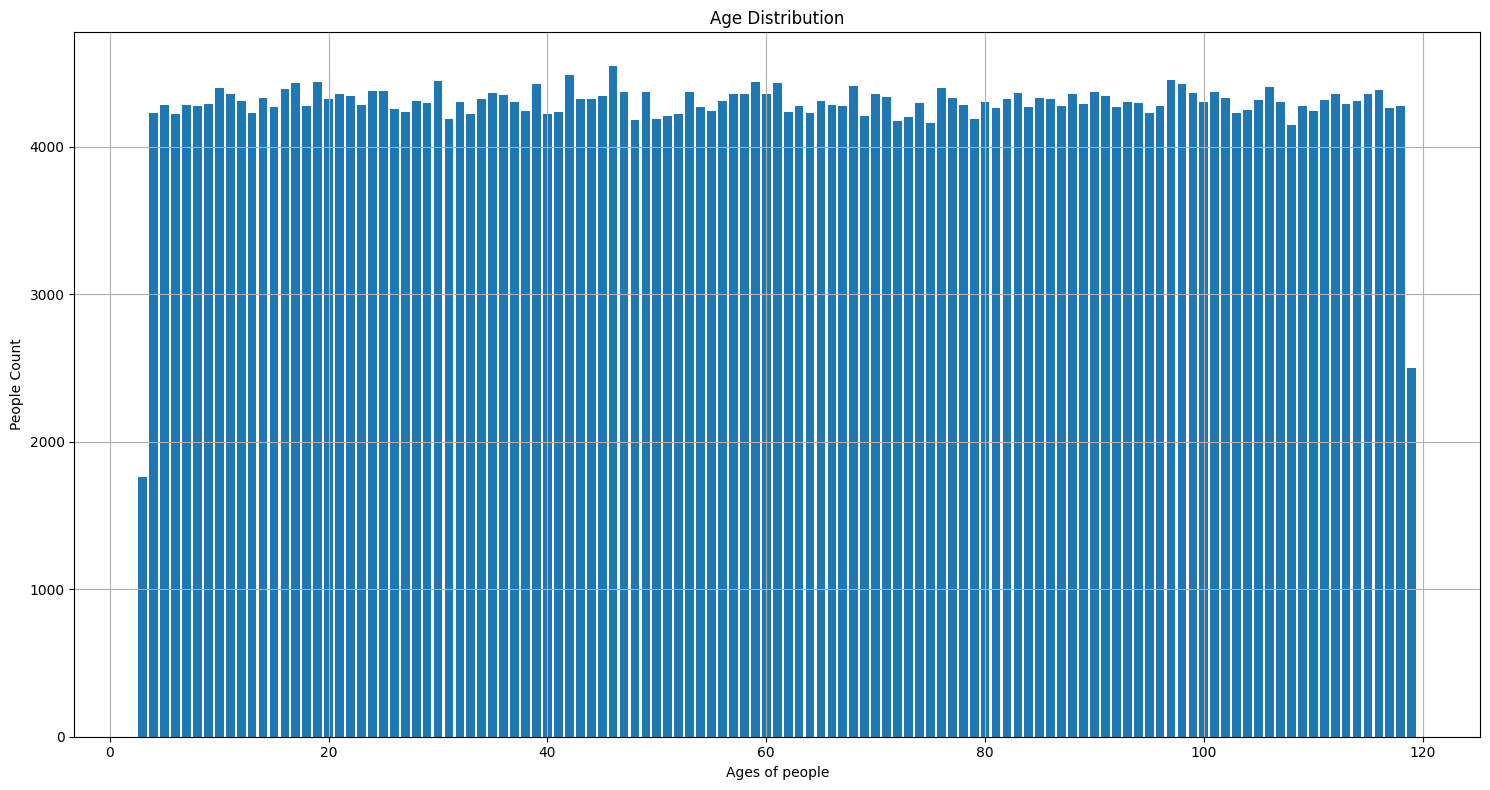

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.bar(result['age'],result['people_count'])
plt.title('Age Distribution')
plt.xlabel('Ages of people')
plt.ylabel('People Count')
plt.tight_layout()
plt.grid(True)
plt.show()